# Etapa 1: Implementação

Implementação do kNN Força Bruta

In [1]:
import collections

def minkowski(r=2):
    return lambda x,y: sum(abs(x - y)**r) ** (1/r)

def knn(observation, data, classes, k=3, dist=minkowski(2)):
    # dists = lista de pares (distancia, rotulo)
    dists = [ (dist(observation, x), y) for (x,y) in list(zip(data, classes)) ]
    dists.sort(key=lambda y: y[0])
    nns = dists[:k]

    # Extrai somente rotulos
    labels = [ n[1] for n in nns ]

    # Retorna lista (de tamanho 1, segundo o parametro) de elemento mais comuns, pares (rotulo, num de occorencias)
    classification = collections.Counter(labels).most_common(1)

    # Retorna apenas o rotulo desse unico elemento
    return classification[0][0]

Implementação do kNN utilizando KD-Tree

In [2]:
class KDTree:
    def __init__(self, data, classes, dim=0):
        self.data = data.copy()
        self.classes = classes.copy()

        # Acha o indice do meio 
        self.sort_indices = self.data[:, dim].argsort()
        self.data = self.data[self.sort_indices]
        self.classes =  self.classes[self.sort_indices]
        self.median_ind = len(self.data)//2

        # Podem existir valores iguais para a direita, achar o mais extremo
        # assim garantimos que quando caminhar-mos pela arvore valores <= estarao a esquerda e
        # > estarao para a direita
        while self.median_ind+1 < len(self.data) and self.data[self.median_ind, dim] == self.data[self.median_ind+1, dim]:
            self.median_ind += 1

        # Divide no meio a dimensao correspondente
        self.value = self.data[self.median_ind]
        self.my_class = classes[self.median_ind]

        self.max_dim = len(self.data[0])
        self.next_dim = (dim+1) % self.max_dim

        # Cria nodos filhos caso possivel
        self.left, self.right = None, None
        if self.median_ind > 0:
            self.left_split  = self.data[:self.median_ind]
            self.left  = KDTree(self.left_split, self.classes[:self.median_ind],  dim = self.next_dim)

        if len(self.data)-self.median_ind-1 > 0:
            self.right_split = self.data[self.median_ind+1:]
            self.right  = KDTree(self.right_split, self.classes[self.median_ind+1:], dim = self.next_dim)


    # Retorna somente a classe
    def knn_wrapper(self, observation, dist=minkowski(2)):
        return self.knn(observation, dim=0, dist=dist)[1]


    # Retorna tupla (coord_do_possivel_nn, class_do_possivel_nn)
    def knn(self, observation, dim=0, dist=minkowski(2)):
        # Se to na folha o possible_nn é o valor da folha
        if self.left == None and self.right == None: 
            return (self.value, self.my_class)

        # Se nao é folha 
        else:
            self.max_dim = len(observation)
            self.next_dim = (dim+1) % self.max_dim

            # Acha good e bad sides
            if observation[dim] <= self.value[dim]:
                self.good_side, self.bad_side = self.left, self.right
            else: 
                self.good_side, self.bad_side = self.right, self.left
            
            # pega possible_nn do good side (se existe)
            if self.good_side is None:
                self.current_dist = float("+inf")
            else: 
                self.possible_nn = self.good_side.knn(observation, self.next_dim, dist=dist)
                self.current_dist = dist(observation, self.possible_nn[0])

            # Compara se esse ponto de corte, a raiz da subarvore atual, pode ser o NN
            self.root_dist = dist(observation, self.value) 
            if self.root_dist < self.current_dist:
                self.possible_nn = (self.value, self.my_class)
                self.current_dist = self.root_dist

            # Tendo ele, verifica se vale a pena chegar o lado ruim
            # O melhor caso do lado ruim seria ter um ponto com cordenadas identicas a nossa observacao, 
            # exceto na dimensao de corte, onde ele teria o valor identico ao plano de corte
            self.ideal_bad_side_nn = observation.copy()
            self.ideal_bad_side_nn[dim] = self.value[dim]
            self.bad_side_ideal_dist = dist(observation, self.ideal_bad_side_nn) 

            if self.bad_side_ideal_dist < self.current_dist:

                # pega nn do bad_side (se bad_side existe)
                if self.bad_side is None:
                    self.bad_side_nn_dist = float("+inf")
                else: 
                    self.bad_side_nn = self.bad_side.knn(observation, self.next_dim, dist=dist)
                    self.bad_side_nn_dist = dist(observation, self.bad_side_nn[0])

                if self.bad_side_nn_dist < self.current_dist:
                    self.possible_nn = self.bad_side_nn

            return self.possible_nn

In [3]:
def naive_bayes():
    pass

# Etapa 2: Treinamento e Inferência

Primeiramente deve-se organizar os dados e dividí-los entre dados de treino e dados de teste

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.DataFrame(pd.read_csv('./penguins.csv'))

# Retirar valores invalidos
data.replace("Na",float("NaN"),inplace=True)
data.dropna(subset=["Culmen Length (mm)"], inplace=True)

# Separar atributo alvo dos restantes
y = data["Species"]
x = data.drop(columns="Species")

# Selecionar apenas colunas numericas relevantes
x = x.drop(columns=["studyName", "Sample Number", "Region", "Island", "Stage", "Individual ID", "Clutch Completion", "Date Egg", "Sex", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)", "Comments"])

# Split dos dados com shuffle
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, shuffle=True, random_state=1337)

# Normalizar dados
scaler = StandardScaler()
normalized_train = scaler.fit_transform(x_train)

normalized_test = scaler.transform(x_test)

# Passar classes para arrays np
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Desempenho do kNN Força Bruta (k=3):

Nota: utilizamos do código do Jupyter Notebook da Semana 3 para desenhar a matriz e calcular o report

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def draw_cm(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    display_confusion_matrix = ConfusionMatrixDisplay(cm)
    display_confusion_matrix.plot(cmap=plt.cm.Blues)
    print(classification_report(y_test, y_hat))

                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.98      1.00      0.99        45
Chinstrap penguin (Pygoscelis antarctica)       1.00      0.95      0.98        21
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        37

                                 accuracy                           0.99       103
                                macro avg       0.99      0.98      0.99       103
                             weighted avg       0.99      0.99      0.99       103



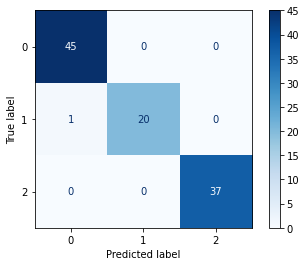

In [6]:
y_hat_brute = []
for (x,y) in zip(normalized_test, y_test):
    y_hat_brute.append(knn(x, normalized_train, y_train, k=3))

draw_cm(y_test, y_hat_brute)


Desempenho do kNN KDTree

                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.96      0.96      0.96        45
Chinstrap penguin (Pygoscelis antarctica)       0.90      0.90      0.90        21
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        37

                                 accuracy                           0.96       103
                                macro avg       0.95      0.95      0.95       103
                             weighted avg       0.96      0.96      0.96       103



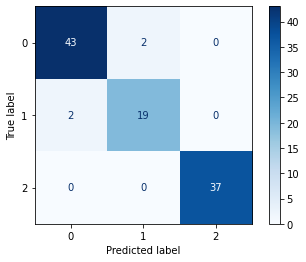

In [7]:
# kd a tree?

# Achei a tree
tree = KDTree(normalized_train, y_train)

y_hat_tree = []
for (x,y) in zip(normalized_test, y_test):
    y_hat_tree.append(tree.knn_wrapper(x))

draw_cm(y_test, y_hat_tree)